In [8]:
import numpy as np
import pandas as pd
from tqdm import tqdm

draw = False

data = pd.read_csv('./data.tsv', sep='\t', index_col='PersonID')

target = data.Age
data.drop(['Age'],axis=1, inplace=True)

## Patch note
モデルを損失関数L(y,F0(x))の傾き(MAEでは残差の符号)を訓練するよう変更  
ステップ倍率を探索し，現在のモデルにかけてから加算するよう変更

In [9]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import graphviz
from sklearn.tree import export_graphviz

f = []
y = []
l = []

# Model Init
y.append([np.mean(target)] * len(target))
pred = np.sum(y, axis=0)
l.append(mae(pred, target))
residual = target - pred
residual /= abs(residual)

In [10]:
for iter_ in tqdm(range(100)):
    f.append(DecisionTreeRegressor(min_samples_leaf=2))
    f[-1].fit(data, residual)
    
    # search for the best gamma
    gammas = np.linspace(0, 10, 100)
    tmp_losses = []
    for gamma_ in gammas:
        tmp_pred = pred + gamma_ * (f[-1].predict(data))
        tmp_losses.append(mae(tmp_pred, target))
    gamma = gammas[np.argmin(tmp_losses)]
    
    pred = pred + gamma * (f[-1].predict(data))
    l.append(mae(pred, target))
    residual = target - pred
    residual /= abs(residual)
    
#     if draw:
#         dot_data = export_graphviz(f[-1],
#                                    feature_names=data.columns,
#                                    filled=True,
#                                    rounded=True,
#                                    out_file=None )
#         graph = graphviz.Source(dot_data)
#         graph.render("trees/simpletree"+str(iter_))
    
    if(iter_ > 1 and (l[-2] - l[-1]) < 1e-4): 
        print('early stop at iter', iter_)
        break

  9%|▉         | 9/100 [00:00<00:08, 10.69it/s]

early stop at iter 9


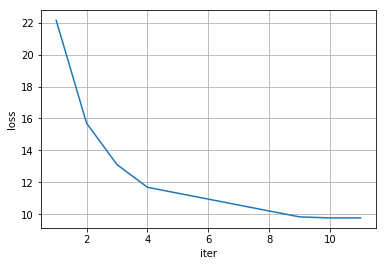

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.xlabel('iter')
plt.ylabel('loss')
plt.grid()
plt.plot(np.arange(1, len(l)+1), l)

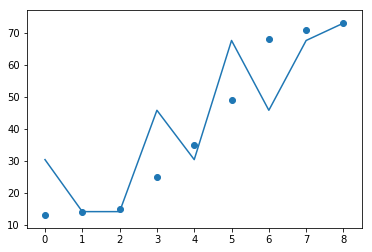

In [12]:
plt.plot(pred)
plt.scatter(range(len(target)), target)

## Original Algorithm

In [13]:
# F[0](data) = argmin(p) sum(L(y, p))
# for m in range(M):
#     residual = -grad( dL(y,F(data))/dF(data) )
#     a[m] = argmin(a, b) sum(residual - b*h(data, a))^2
#     p[m] = argmin(p) sum(L(y, F[m-1](data) + p*h(data, a[m])))
#     F[m] = F[m-1](data) + p[m]*h(data, a[m])
# sum(F)